In [1]:
"""Topic: Use different regression models such as linear, polynomial, lasso, and ridge to predict amount of fantasy points an NFL Wide Receivers will have in the following game based off of previous game stats.

Independent Variable (Features): Rushing Yards, Rushing Touchdowns, Carries, Receptions, Yards/Target,Receptions/Yard, Receiving Touchdowns, Receiving Yards, Fumbles

Dependent Variable (Target): Fantasy Football Points for next game 

Source: Data scraped from Pro-Football-Reference

Methodology: Apply all regression models as aforementioned and compare Train, Validation, and Test R^2 values to determine best for model. Utilize other regression models such as LASSO and Ridge to Feature Engineer. Create running average of statistics for entire 2019 season (ie.: If Game 3 and predicting Fantasy Points for Game 4, then Game 3 statistics will be an average of games 1, 2, and 3.)

Deliverable: Present model with the best RSME score to determine how many points model comes within actual score. Reduce RSME as much as possible to create most accurate model. 

Future Iterations: Aggregate Features on 4-week running averages (ie.: Game 5 features predicting Fantasy Points for Game 6, average statistics from Games 2,3,4, and 5)
"""

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../helper_functions')

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_wide_receiver_headers
from get_df import get_wide_receiver_df, all_individual_stats, fantasy_points

import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import patsy
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot, PredictionError

import statsmodels.formula.api as smf
import statsmodels.api as sm


# Section 1

## Section 1.1
Web scrape data from Pro-Football-Reference for Wide Receivers with around 500 receiving yards or above. Pull individual statistics for each running back, for each game for the 2019 season. 

In [442]:
df_all_wide_receivers_2019 = all_position_stats('2019','receiving', 64)
df_all_wide_receivers_2019.columns = all_wide_receiver_headers('2019','receiving')

df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']] = df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']].apply(pd.to_numeric)
df_all_wide_receivers_2019 = df_all_wide_receivers_2019[(df_all_wide_receivers_2019.Pos != 'RB') & (df_all_wide_receivers_2019.Pos != 'rb')
& (df_all_wide_receivers_2019.Pos != 'TE')]
df_all_wide_receivers_2019.to_pickle("../pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019 = pd.read_pickle("../pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019


,Link,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb
Michael Thomas,/players/T/ThomMi05.htm,Michael Thomas*+,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,9.3,107.8,1
Keenan Allen,/players/A/AlleKe00.htm,Keenan Allen*,LAC,27,WR,16,16,149,104,69.8%,1199,11.5,6,63,45,8.0,6.5,74.9,0
DeAndre Hopkins,/players/H/HopkDe00.htm,DeAndre Hopkins*+,HOU,27,WR,15,15,150,104,69.3%,1165,11.2,7,68,43,7.8,6.9,77.7,0
Julian Edelman,/players/E/EdelJu00.htm,Julian Edelman,NWE,33,WR,16,13,153,100,65.4%,1117,11.2,6,54,44,7.3,6.3,69.8,3
Julio Jones,/players/J/JoneJu02.htm,Julio Jones *,ATL,30,WR,15,15,157,99,63.1%,1394,14.1,6,77,54,8.9,6.6,92.9,1
Allen Robinson,/players/R/RobiAl02.htm,Allen Robinson,CHI,26,WR,16,15,154,98,63.6%,1147,11.7,7,63,49,7.4,6.1,71.7,0
Cooper Kupp,/players/K/KuppCo00.htm,Cooper Kupp,LAR,26,WR,16,14,134,94,70.1%,1161,12.4,10,51,66,8.7,5.9,72.6,3
Tyler Boyd,/players/B/BoydTy00.htm,Tyler Boyd,CIN,25,WR,16,15,148,90,60.8%,1046,11.6,5,51,47,7.1,5.6,65.4,2
Robert Woods,/players/W/WoodRo02.htm,Robert Woods,LAR,27,WR,15,15,139,90,64.7%,1134,12.6,2,54,48,8.2,6.0,75.6,0
D.J. Moore,/players/M/MoorD.00.htm,D.J. Moore,CAR,22,WR,15,15,135,87,64.4%,1175,13.5,4,63,52,8.7,5.8,78.3,2


In [443]:
all_wide_receivers_2019 = all_individual_stats(get_wide_receiver_df, df_all_wide_receivers_2019, '2019')
all_wide_receivers_2019.to_pickle("../pickled/all_wide_receivers_2019.pkl")

all_wide_receivers_2019 = pd.read_pickle("../pickled/all_wide_receivers_2019.pkl")

all_wide_receivers_2019

,index,Name,Targets,Receptions,Receiving_Yards,Y/R,Receiving_TD,Y/Tgt,Carries,Rush_Yards,Yards_per_Carry
0,0,Michael Thomas,13,10,123,12.30,0,9.46,0.0,0,NaN
1,1,Michael Thomas,13,10,89,8.90,0,6.85,0.0,0,NaN
2,2,Michael Thomas,7,5,54,10.80,1,7.71,0.0,0,NaN
3,3,Michael Thomas,9,9,95,10.56,0,10.56,0.0,0,NaN
4,4,Michael Thomas,13,11,182,16.55,2,14.00,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
624,10,Robby Anderson,5,4,86,21.50,1,17.20,0.0,0,NaN
625,11,Robby Anderson,10,7,101,14.43,0,10.10,0.0,0,NaN
626,12,Robby Anderson,11,7,117,16.71,1,10.64,1.0,4,4.0
627,13,Robby Anderson,6,4,66,16.50,0,11.00,0.0,0,NaN


In [444]:
all_wide_receivers_fantasy_2019 = all_individual_stats(fantasy_points, df_all_wide_receivers_2019, '2019')
all_wide_receivers_fantasy_2019.to_pickle("../pickled/all_wide_receivers_fantasy_2019.pkl")

all_wide_receivers_fantasy_2019 = pd.read_pickle("../pickled/all_wide_receivers_fantasy_2019.pkl")
all_wide_receivers_fantasy_2019

,index,Name,Fantasy_Points
0,1,Michael Thomas,8.9
1,2,Michael Thomas,11.4
2,3,Michael Thomas,9.5
3,4,Michael Thomas,30.2
4,5,Michael Thomas,8.9
...,...,...,...
624,11,Robby Anderson,10.1
625,12,Robby Anderson,18.1
626,13,Robby Anderson,8.6
627,14,Robby Anderson,9.2


## Section 1.1 
Group by Wide Receivers and calculate running average. Add in Fantasy Points columns and delete unneeded columns after completing Featuring Engineering and Regularization.

In [454]:
df_receiving_fantasy_2019 = all_wide_receivers_2019.iloc[:,1:2]

df_receiving_fantasy_2019 = pd.concat([df_receiving_fantasy_2019, all_wide_receivers_2019.iloc[:,2:]],axis=1)

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.dropna()

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.groupby('Name').expanding().mean().reset_index()

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.sort_values('level_1').reset_index()

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.drop(['index','level_1'],axis=1)

df_receiving_fantasy_2019['Fantasy_Points'] = all_wide_receivers_fantasy_2019.iloc[:,-1:]

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.rename(columns={'Y/R':'Yards_per_Reception'})

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.drop(['Carries','Yards_per_Carry', 'Rush_Yards'], axis=1)

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.dropna()

df_receiving_fantasy_2019.to_pickle("../pickled/df_receiving_fantasy_2019.pkl")

df_receiving_fantasy_2019 = pd.read_pickle("../pickled/df_receiving_fantasy_2019.pkl")

df_receiving_fantasy_2019 = df_receiving_fantasy_2019.iloc[:,1:]

df_receiving_fantasy_2019

,Targets,Receptions,Receiving_Yards,Yards_per_Reception,Receiving_TD,Y/Tgt,Fantasy_Points
0,11.000000,11.000000,112.000000,10.180000,1.000000,10.180000,8.9
1,17.000000,13.000000,183.000000,14.080000,2.000000,10.760000,11.4
2,14.000000,10.500000,125.500000,11.290000,1.000000,8.470000,9.5
3,12.666667,8.666667,107.333333,12.260000,0.666667,8.013333,30.2
4,11.000000,8.000000,48.000000,6.000000,1.000000,4.360000,8.9
...,...,...,...,...,...,...,...
204,7.000000,3.166667,47.500000,13.838333,0.333333,6.555000,0.3
205,6.571429,3.000000,44.285714,13.647143,0.285714,6.511429,10.6
206,6.625000,3.250000,42.625000,12.716250,0.375000,6.251250,14.0
207,6.444444,3.111111,39.777778,12.247778,0.333333,5.934444,20.7


In [455]:
df_receiving_fantasy_2019.corr()

,Targets,Receptions,Receiving_Yards,Yards_per_Reception,Receiving_TD,Y/Tgt,Fantasy_Points
Targets,1.000000,0.805073,0.552734,-0.159224,0.167516,-0.221789,0.052459
Receptions,0.805073,1.000000,0.595016,-0.260062,0.185178,-0.030228,0.051008
Receiving_Yards,0.552734,0.595016,1.000000,0.449738,0.471422,0.585652,0.044550
Yards_per_Reception,-0.159224,-0.260062,0.449738,1.000000,0.318438,0.827689,-0.045014
Receiving_TD,0.167516,0.185178,0.471422,0.318438,1.000000,0.307424,0.098180
Y/Tgt,-0.221789,-0.030228,0.585652,0.827689,0.307424,1.000000,-0.022399
Fantasy_Points,0.052459,0.051008,0.044550,-0.045014,0.098180,-0.022399,1.000000


# Section 2
## Section 2.1 
Correlate features to determine most important features.

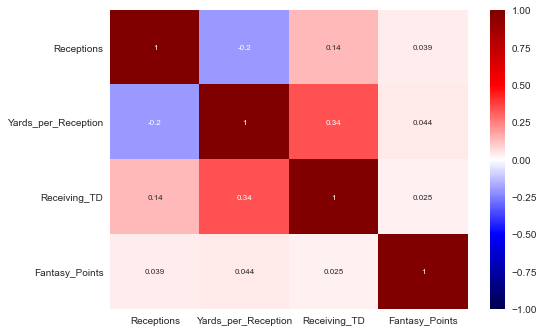

In [399]:
# example of a better corr matrix
# do this for all running backs, wide receivers, and quarterbacks
features_map = sns.heatmap(df_receiving_fantasy_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":8})
fig = features_map.get_figure()
fig.savefig("features_map.png") 

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

<AxesSubplot:title={'center':'Pearson Ranking of 4 Features'}>

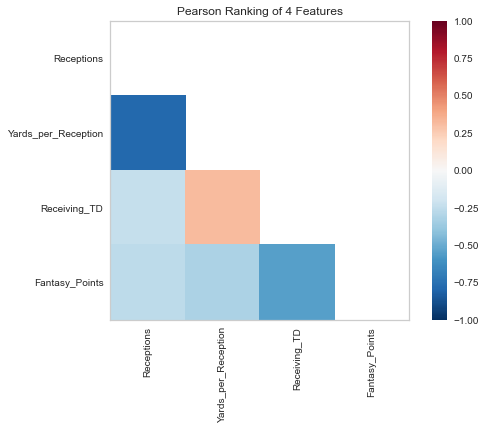

In [400]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_receiving_fantasy_2019.corr())
visualizer.show(outpath="pcoords.png")

<Figure size 1440x540 with 0 Axes>

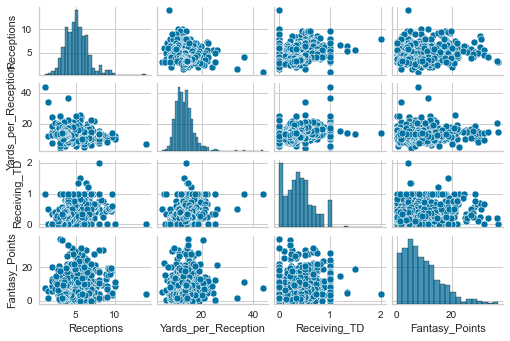

In [401]:
# do this for all running backs, wide receivers, and quarterbacks
plt.figure(figsize = [20,7.5])

sns.pairplot(df_receiving_fantasy_2019, height=1.2, aspect=1.5);

# Section 3: Cross-Validation For Model Selection

Demonstrates two typical workflows for using validation data to select models. It also demonstrates the use of some utility methods like generating **polynomial features** and **scaling features** when applying regularization.

**Contents Below**

> 1. Basic validation method: Train/validation/test
> 2. Rigorous validation method: Cross-validation/test
> 3. Making CV less manual via scikit-learn

## 3.1 Simple Validation Method: Train / Validation / Test

Break data into 3 portions: 60% for training, 20% for validation (used to select the model), 20% for final testing evaluation.

In [456]:
X, y = df_receiving_fantasy_2019.drop('Fantasy_Points',axis=1), df_receiving_fantasy_2019['Fantasy_Points']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) 

In [457]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

Model Setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

Also, we need to get **polynomial features** for the poly model

In [458]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Higher alpha = strong regularization strength 
lm_las = Lasso(alpha=0.01)
lm_reg = Ridge(alpha=0.01)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

<AxesSubplot:>

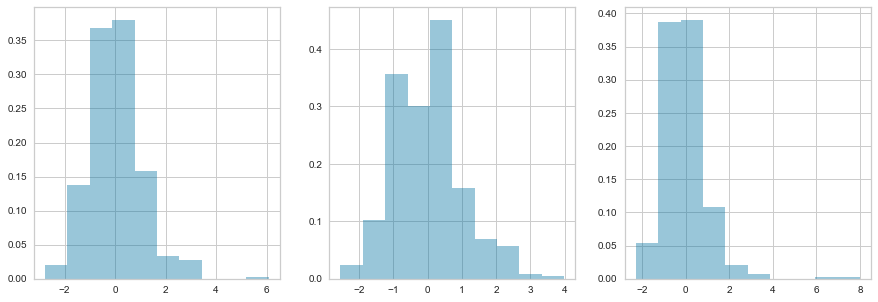

In [382]:
# Plot histograms of a few transformed variables
# Note that they seem to have means of 0 and stddevs of 1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(X_train_scaled[:, 0], label='feature 1', ax=axes[0], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 1], label='feature 2', ax=axes[1], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 2], label='feature 3', ax=axes[2], kde=False, bins=10, norm_hist=True)


## Section 3.2 
Calculate R^2 Train, Validation, and Test values for Linear, Polynomial, Lass, and Regression

In [459]:
lm.fit(X_train_scaled, y_train)
print(f'Linear Regression Train R^2: {lm.score(X_train_scaled, y_train):.3f}')
print(f'Linear Regression Val R^2: {lm.score(X_val_scaled, y_val):.3f}')
print(f'Linear Regression Test R^2: {lm.score(X_test_scaled, y_test):.3f}\n')

lm_las.fit(X_train_scaled, y_train)

print(f'Lasso Regression Train R^2: {lm_las.score(X_train_scaled, y_train):.3f}')
print(f'Lasso Regression Val Scaled R^2: {lm_las.score(X_val_scaled, y_val):.3f}')
print(f'Lasso Regression Test R^2: {lm_las.score(X_test_scaled, y_test):.3f}\n')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression Train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression Val Scaled R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression Test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}\n')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression Train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
print(f'Degree 2 polynomial regression Val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression Test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression Train R^2: 0.015
Linear Regression Val R^2: -0.016
Linear Regression Test R^2: -0.093

Lasso Regression Train R^2: 0.015
Lasso Regression Val Scaled R^2: -0.011
Lasso Regression Test R^2: -0.085

Ridge Regression Train R^2: 0.015
Ridge Regression Val Scaled R^2: -0.016
Ridge Regression Test R^2: -0.093

Degree 2 polynomial regression Train R^2: 0.148
Degree 2 polynomial regression Val R^2: -4.027
Degree 2 polynomial regression Test R^2: -2.859


So having run this validation step, we see that the evidence points to Poloynomial having the highest Train R^2 but the highest Test R^2s are by Linear, Ridge, and Lasso. So our validation process lets us **select** that choice of model, and as our final step we retrain it on the entire chunk of train/val data and see how it does on test data:  

# Section 4 Rigorous Validation Method: Cross-Validation / Test

Break data into 2 portions: 80% for a cross-validated training process, and 20% for final testing evaluation. 

The idea of CV is to make efficient use of the data available to us (using 80% instead of 60% above), while also performing multiple validation checks. For k-fold CV, we come up with k train/validation splits of the whole chunk of data, in such a way that **each observation is in the validation set exactly 1 time**. 

We'll focus on Linear, Ridge, and Lasso regression (we also can feel pretty comfortable throwing out the full degree 2 polynomial regression based on the poor results above!) As we loop through our CV folds, we will train and validate both models and collect the results to compare at the end. Note that we scale the training features within the CV loop.

## Section 4.1 
Linear, Lasso, and Ridge Cross-Validation Scores and RSME

In [460]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [461]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_train_r2s, cv_lm_val_r2s, cv_lm_las_train_r2s, cv_lm_las_val_r2s, cv_lm_reg_train_r2s, cv_lm_reg_val_r2s, cv_lm_poly_train_r2s, cv_lm_poly_val_r2s, rmses, rmses_las, rmses_reg, rmses_poly = [], [], [], [], [], [], [], [], [], [], [], [] #collect the validation results for models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm.fit(X_train, y_train)
    cv_lm_train_r2s.append(lm.score(X_train, y_train))
    cv_lm_val_r2s.append(lm.score(X_val, y_val))

    lm_rmse = mean_squared_error(y_val, lm.predict(X_val), squared=False)
    rmses.append(lm_rmse)

    # setup for ridge, lasso, and polynomial
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #lass with feature scaling 
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_train_r2s.append(lm_las.score(X_val_scaled,y_val))
    cv_lm_las_val_r2s.append(lm_las.score(X_val_scaled, y_val))

    lm_las_rmse = mean_squared_error(y_val, lm_las.predict(X_val_scaled), squared=False)
    rmses_las.append(lm_las_rmse)

    #ridge with feature scaling
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_train_r2s.append(lm_reg.score(X_val_scaled,y_val))
    cv_lm_reg_val_r2s.append(lm_reg.score(X_val_scaled, y_val))

    lm_reg_rmse = mean_squared_error(y_val, lm_reg.predict(X_val_scaled), squared=False)
    rmses_reg.append(lm_reg_rmse)

    #polynomial with feature scaling
    lm_poly.fit(X_train_scaled, y_train)
    cv_lm_poly_train_r2s.append(lm_las.score(X_val_scaled,y_val))
    cv_lm_poly_val_r2s.append(lm_poly.score(X_val_scaled, y_val))

    lm_poly_rmse = mean_squared_error(y_val, lm_poly.predict(X_val_scaled), squared=False)
    rmses_poly.append(lm_poly_rmse)

print('Simple regression scores: ', cv_lm_val_r2s)
print('Lasso scores: ', cv_lm_las_val_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_val_r2s, '\n')
print('Polynomial scores:', cv_lm_poly_val_r2s, '\n')

print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_lm_las_train_r2s):.3f} +- {np.std(cv_lm_las_train_r2s):.3f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_lm_las_val_r2s):.3f} +- {np.std(cv_lm_las_val_r2s):.3f}')
print(f'Lasso mean RMSE: {np.mean(rmses_las):.3f} +- {np.std(rmses_las):.3f}\n')

print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_lm_reg_train_r2s):.3f} +- {np.std(cv_lm_reg_train_r2s):.3f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_lm_reg_val_r2s):.3f} +- {np.std(cv_lm_reg_val_r2s):.3f}')
print(f'Ridge mean RMSE: {np.mean(rmses_reg):.3f} +- {np.std(rmses_reg):.3f}\n')

print(f'Polynomial mean cv r^2 (TRAIN): {np.mean(cv_lm_poly_train_r2s):.3f} +- {np.std(cv_lm_poly_train_r2s):.3f}')
print(f'Polynomial mean cv r^2 (VAL): {np.mean(cv_lm_poly_val_r2s):.3f} +- {np.std(cv_lm_poly_val_r2s):.3f}')
print(f'Polynomial mean RMSE: {np.mean(rmses_poly):.3f} +- {np.std(rmses_poly):.3f}\n')

print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lm_train_r2s):.3f} +- {np.std(cv_lm_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lm_val_r2s):.3f} +- {np.std(cv_lm_val_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [-0.13094432085430463, -0.11771173887863329, -0.1210868145346784, -0.3434380237872561, -0.05212478092037376]
Lasso scores:  [-0.1285256165769213, -0.1167958594630476, -0.12027199825120527, -0.32530164485773105, -0.03297410589201766] 

Ridge scores:  [-0.1309174150639869, -0.11767177497576453, -0.12105567979539589, -0.3432373792039123, -0.051914593043256074] 

Polynomial scores: [-0.13094432085430463, -0.11771173887863351, -0.12108681453467907, -0.3434380237872561, -0.0521247809203742] 

Lasso mean cv r^2 (TRAIN): -0.145 +- 0.097
Lasso mean cv r^2 (VAL): -0.145 +- 0.097
Lasso mean RMSE: 7.033 +- 0.887

Ridge mean cv r^2 (TRAIN): -0.153 +- 0.099
Ridge mean cv r^2 (VAL): -0.153 +- 0.099
Ridge mean RMSE: 7.056 +- 0.872

Polynomial mean cv r^2 (TRAIN): -0.145 +- 0.097
Polynomial mean cv r^2 (VAL): -0.153 +- 0.099
Polynomial mean RMSE: 7.056 +- 0.872

Simple mean cv r^2 (TRAIN): 0.040 +- 0.012
Simple mean cv r^2 (VAL): -0.153 +- 0.099
Simple mean RMSE: 7.056 +- 0.8

The cross validation method cements simple linear regression being better than Lasso, Ridge, and Polynomial with a higher R^2 Train value. Unfortunately the Validation R^2 has a negative value which means it is overfit.

**Since k-fold is more reliable than a single validation set, we are assured by the linear regression model**. This shows the dangers of relying on simple validation methods, especially when our sample sizes are small.

## Section 4.2
Determining coefficients to remove based on Ridge and Lasso coefficient values

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_ (ish): will never fully discard features

Lasso coefficient scores of 0 have been removed for this final mode set.

In [462]:
list(zip(df_receiving_fantasy_2019.columns[:-1],lm_las.coef_))

[('Targets', 1.4345044214002958),
 ('Receptions', -0.9124116590863122),
 ('Receiving_Yards', -0.2713423360258178),
 ('Yards_per_Reception', -1.1607258828087221),
 ('Receiving_TD', 1.1422481927090977),
 ('Y/Tgt', 0.6845163734518122)]

In [463]:
list(zip(df_receiving_fantasy_2019.columns[:-1],lm_reg.coef_))

[('Targets', 2.000378636809241),
 ('Receptions', -1.3087933565847445),
 ('Receiving_Yards', -0.6120230945961177),
 ('Yards_per_Reception', -1.6299264923470036),
 ('Receiving_TD', 1.2186029797392106),
 ('Y/Tgt', 1.3722418267755008)]

# Section 5: Tuning Regularization Strength via Validation

Here we will attempt to find the "best" value of the regularization strength alpha for this feature and target set and the LASSO and Ridge models. We'll use simple validation (single train/valid split) as our model selection method.

We will first decide on a vector of "candidate" alpha values.  Then, for each candidate value, we run the following steps:

> 1. Fit a LASSO and Ridge model on the training data
> 2. Using the newly trained model, make predictions on the validation data
> 3. Run evaluation metrics on validation

Then we plot how the errors change for the different values of alpha, and see where alpha minimizes our error metric on the validation data. This value of alpha is the one we would select for our final model.

## Section 5.1: LASSO Regularization Tuning

In [464]:
test_set_pred = lm_las.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

18.67114862128016

In [362]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

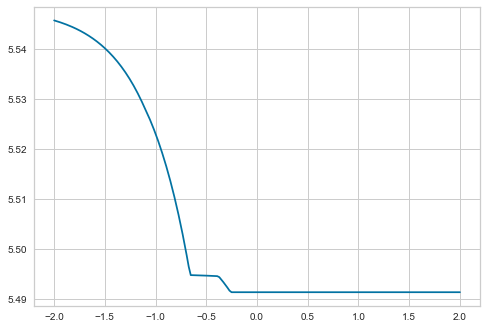

In [363]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [364]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

5.491333995037221

In [365]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.5607169938205459

## Section 5.2: Ridge Regularization Tuning

In [366]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('Ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

In [367]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

5.527140671863538

In [368]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

100.0

## Section 5.3: LassoCV Regularization

In [369]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_las_CV = LassoCV(alphas = alphavec, cv=5)
lm_las_CV.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [370]:
# This is the best alpha value it found - higher from the value
# selected using simple validation
lm_las_CV.alpha_

0.01

## Section 5.4: RidgeCV Regularization

In [371]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_reg_CV = RidgeCV(alphas = alphavec, cv=5)
lm_reg_CV.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [372]:
# This is the best alpha value it found - higher from the value
# selected using simple validation
lm_reg_CV.alpha_

65.93188271333548

#### Inputting either alphas for LASSO and Ridge did not impact the R^2 values significantly

# Section 6: Models

Comparing the Actual vs. Predicted values to determine accuracy of model 

## Section 6.1: Linear Regression Modeling 


Text(0, 0.5, 'Actual Values')

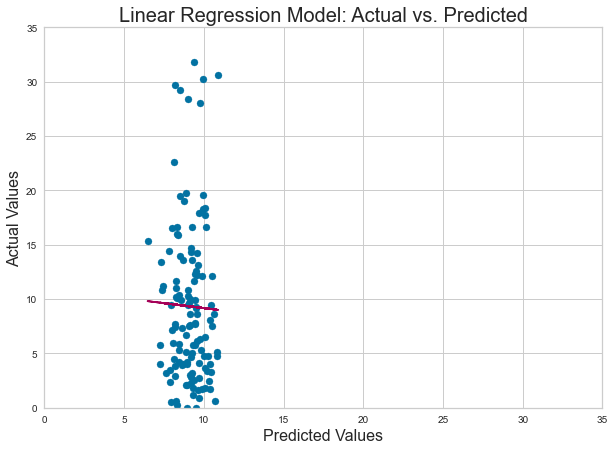

In [373]:
lm_predict = lm.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_predict, y_test)
ax = plt.gca()

z = np.polyfit(lm_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_predict, p(lm_predict), "m-")

plt.xlim(0,35)
plt.ylim(0,35)

plt.title('Linear Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Sectin 6.2 Lasso Regression Modeling 

Text(0, 0.5, 'Actual Values')

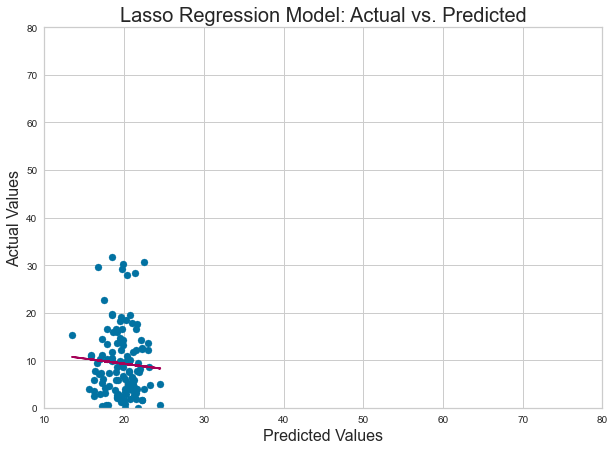

In [348]:
lm_las_predict = lm_las.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_las_predict, y_test)

z = np.polyfit(lm_las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_las_predict, p(lm_las_predict), "m-")

plt.xlim(10,80)
plt.ylim(0,80)

plt.title('Lasso Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Section 6.3 Ridge Regression Modeling

Text(0, 0.5, 'Actual Values')

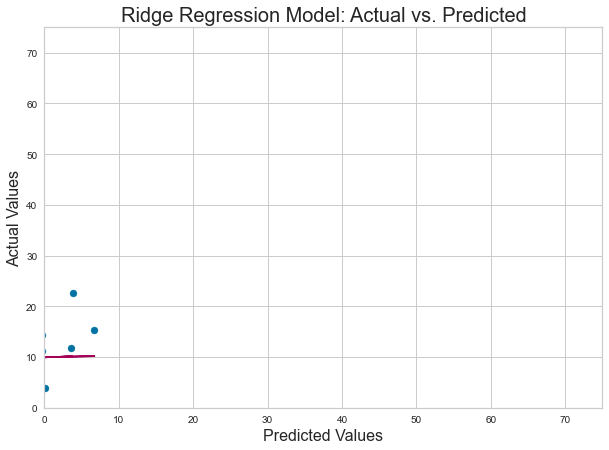

In [349]:
lm_reg_predict = lm_reg.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_reg_predict, y_test)

z = np.polyfit(lm_reg_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_reg_predict, p(lm_reg_predict), "m-")

plt.xlim(0,75)
plt.ylim(0,75)

plt.title('Ridge Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

Text(0, 0.5, 'Actual Values')

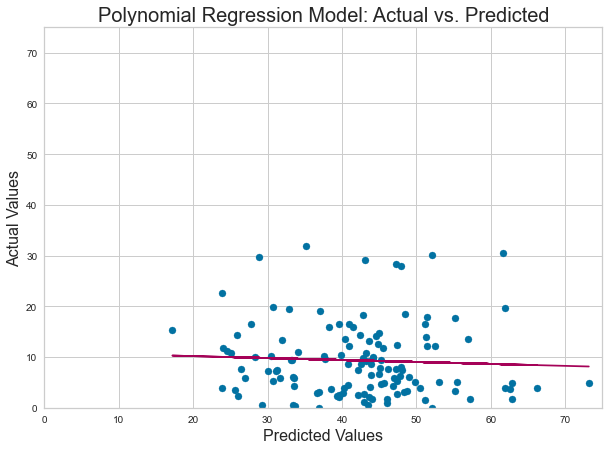

In [276]:
lm_poly_predict = lm_poly.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_poly_predict, y_test)

z = np.polyfit(lm_poly_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_poly_predict, p(lm_poly_predict), "m-")

plt.xlim(0,75)
plt.ylim(0,75)

plt.title('Polynomial Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Section 6.4 Test vs. Predicted Values 
Comparing the Testing Values with the Predicted values and calculating the mean of the scores to analyze the difference.

In [270]:
df_receiving_fantasy_2019_predicted = df_receiving_fantasy_2019
df_receiving_fantasy_2019_predicted['Tested_Fantasy_Points'] = pd.DataFrame(y_test)
df_receiving_fantasy_2019_predicted['Predicted_Fantasy_Points'] = pd.DataFrame(lm_predict)
df_receiving_fantasy_2019_predicted['Name'] = all_wide_receivers_2019.iloc[:,1:2]
df_receiving_fantasy_2019_predicted = df_receiving_fantasy_2019_predicted.dropna()
df_receiving_fantasy_2019_predicted.to_csv('Final_WR_Dataframe.csv', index=False)
df_receiving_fantasy_2019_predicted


,Receiving_Yards,Fantasy_Points,Tested_Fantasy_Points,Predicted_Fantasy_Points,Name
3,90.250000,30.2,30.2,9.253980,Michael Thomas
10,112.909091,4.8,4.8,10.176339,Michael Thomas
13,110.857143,19.6,19.6,8.720557,Michael Thomas
14,112.533333,3.7,3.7,8.738520,Michael Thomas
16,110.500000,30.6,30.6,9.097780,Keenan Allen
17,134.666667,4.8,4.8,9.360015,Keenan Allen
18,113.000000,1.8,1.8,8.912293,Keenan Allen
20,83.833333,6.1,6.1,9.132925,Keenan Allen
21,80.571429,5.3,5.3,9.425799,Keenan Allen
23,73.000000,8.6,8.6,9.419942,Keenan Allen


In [272]:
df_receiving_fantasy_2019_predicted.iloc[:,-3:-1].mean()

Tested_Fantasy_Points       10.573684
Predicted_Fantasy_Points     9.153422
dtype: float64

# Section 7: Residuals Plots 

Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random which the model shows.

In [274]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Receiving_Yards', data=df_receiving_fantasy_2019, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.902
Date:                Sun, 11 Oct 2020   Prob (F-statistic):              0.168
Time:                        22:29:37   Log-Likelihood:                -2092.2
No. Observations:                 629   AIC:                             4188.
Df Residuals:                     627   BIC:                             4197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.9283      0.934      8.489      0.000       6.094       9.762
Receiving_Yards     0.0183      0.013      1.379      0.168      -0.008       0.044
==============================================================================
Omnibus:                      111.314   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.402
Skew:                           1.119   Prob(JB):                     1.10e-39
Kurtosis:                       4.354   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

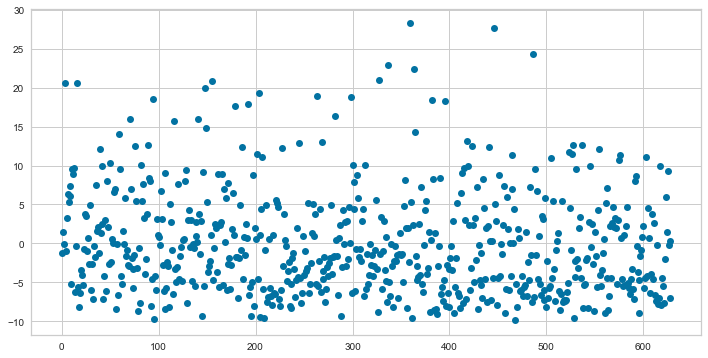

In [275]:
fit.resid.plot(style='o',figsize=(12,6))